# Evaluating our machine learning models

In [1]:
import warnings
warnings.filterwarnings("ignore")

Now that we've run a few classifications models, what more could we need to know about machine learning in neuroimaging ?
A lot, actually !
Everything that we've done to date falls broadly under the umbrella of "feature engineering."
When applying machine learning, however, equally important are (1) the model that we train to generate predictions and (2) how we assess the generalizability of our learned model.

In this notebook, we'll focus on (2).
In particular, we'll highlight the importance of appropriate cross-validation methods.
First, we can look at a recent review {cite}`Poldrack_2020` showing common cross-validation methods in neuroimaging:

```{figure} ../images/poldrack-2020-fig3.jpg
---
height: 250px
name: cv-usage
---
From {cite}`Poldrack_2020`, depicting results from a review of 100 studies (2017–2019) claiming prediction on fMRI data.
_Panel A_ shows the prevalence of cross-validation methods in this sample.
_Panel B_ shows a histogram of associated sample sizes.
```

As you can see, many neuroscience researchers are not using cross-validation at all !
We will briefly overview _why_ cross-validation is so important to achieve, as well as different strategies for cross-validation that are in use with neuroimaging data.
We then provide examples of appropriate and inappropriate cross-validation within the `development_fmri` dataset. 
One thing to emphasize, here : best practice is always to have a separate, held-out validation set !
This will allow us to make more meaningful statements about our learned model,
but it requires having access to more data.

## Why cross-validate ?

First, let's formalize the problem that cross-validation aims to solve, using notation from {cite}`Little_2017`. 

For $N$ observations, we can choose a variable $y \in \mathbb{R}^n$ that we are trying to predict from data $X \in \mathbb{R}^{n \times p}$⁠.
For example, we may have neuroimaging data for 155 participants, from which we are trying to predict their age group as either a child or an adult.

The machine learning problem is to estimate a function $\hat{f}_{\{ train \}}$ that predicts best $y$ from $X$.
In other words, we want to minimize an error $\mathcal{E}(y,\hat{f}(X))$⁠.

The challenge is that we are interested in this error on new, unknown, data.
Thus, we would like to know the expectaction of the error for $(y, X)$ drawn from their unknown distribution:

$$
  \mathbb{E}_{(y,X)} [\mathcal{E}(y,\hat{f}(X))].
$$

From this we note two important points.
  1. Evaluation procedures _must_ test predictions of the model on held-out data that is independent from the data used to train the model.
  2. Cross-validation procedures that repeating the train-test split many times to vary the training set also allow use to ask a related question:
    given _future_ data to train a machine learning method on a clinical problem, what is the error that I can expect on new data?

## Forms of cross-validation

Given the importance of cross-validation in machine learning, many different schemes exist.
The [scikit-learn documentation has a section](https://scikit-learn.org/stable/modules/cross_validation.html) just on this topic, which is worth reviewing in full.
Here, we briefly highlight how cross-validation impacts our estimates in our example dataset.

## Testing cross-validation schemes in our example dataset.

We'll keep working with the same `development_dataset`, though this time we'll fetch all 155 subjects.
Again, we'll derive functional connectivity matrices for each participant, though this time we'll only consider the "correlation" measure.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import (datasets, maskers, plotting)
from nilearn.connectome import ConnectivityMeasure
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import LinearSVC

development_dataset = datasets.fetch_development_fmri(
    data_dir='/home/jovyan/shared-readwrite/'
)
msdl_atlas = datasets.fetch_atlas_msdl()

masker = maskers.NiftiMapsMasker(
    msdl_atlas.maps, resampling_target="data",
    t_r=2, detrend=True,
    low_pass=0.1, high_pass=0.01).fit()
correlation_measure = ConnectivityMeasure(kind='correlation')

pooled_subjects = []
groups = []  # child or adult

for func_file, confound_file, phenotypic in zip(
        development_dataset.func,
        development_dataset.confounds,
        development_dataset.phenotypic):

    time_series = masker.transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    groups.append(phenotypic['Child_Adult'])

_, classes = np.unique(groups, return_inverse=True)
pooled_subjects = np.asarray(pooled_subjects)

In [our classification example](class-example), we used `StratifiedShuffleSplit` for cross-validation.
This method preserves the percentage of samples for each class across train and test splits;
that is, the percentages of child and adult participants in our classification example.

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay
# First, re-generate our cross-validation scores for StratifiedShuffleSplit

strat_scores = []

cv = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=30)
for train, test in cv.split(pooled_subjects, groups):
    connectivity = ConnectivityMeasure(kind="correlation", vectorize=True)
    connectomes = connectivity.fit_transform(pooled_subjects[train])
    classifier = LinearSVC().fit(connectomes, classes[train])
    predictions = classifier.predict(
        connectivity.transform(pooled_subjects[test]))
    strat_scores.append(accuracy_score(classes[test], predictions))

print(f'StratifiedShuffleSplit Accuracy: {np.mean(strat_scores):.2f} ± {np.std(strat_scores):.2f}')

StratifiedShuffleSplit Accuracy: 0.94 ± 0.02


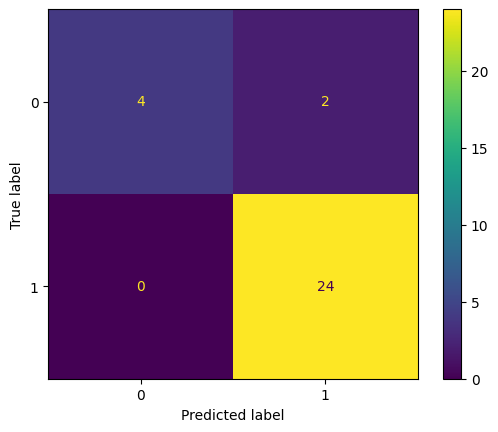

In [4]:
# Then, generate a confusion matrix for the trained classifier
# We'll plot just the last CV fold for now
cm = ConfusionMatrixDisplay.from_predictions(classes[test], predictions)

What if we don't account for age groups when generating our cross-validation folds ?
We can test this by using `KFold`, which does not stratify by group membership.

In [5]:
# Then, compare with cross-validation scores for ShuffleSplit

from sklearn.model_selection import KFold
kfold_scores = []

cv = KFold(n_splits=5)
for train, ktest in cv.split(pooled_subjects):
    connectivity = ConnectivityMeasure(kind="correlation", vectorize=True)
    connectomes = connectivity.fit_transform(pooled_subjects[train])
    classifier = LinearSVC().fit(connectomes, classes[train])
    kfold_predictions = classifier.predict(
        connectivity.transform(pooled_subjects[ktest]))
    kfold_scores.append(accuracy_score(classes[ktest], kfold_predictions))

print(f'KFold Accuracy: {np.mean(kfold_scores):.2f} ± {np.std(kfold_scores):.2f}')

KFold Accuracy: 0.77 ± 0.37


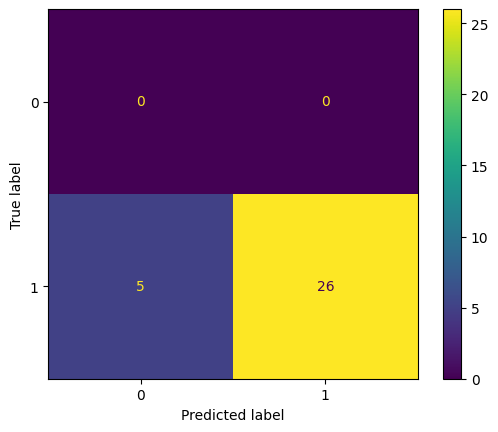

In [6]:
# Then, generate a confusion matrix for the trained classifier
# We'll plot just the last CV fold for now
cm = ConfusionMatrixDisplay.from_predictions(classes[ktest], kfold_predictions)

Now our classifer is only shown the `child` age group label at testing,
but it's predicting both child and adult labels !

### Beyond accuracy: The Receiver-Operator Characteristic (ROC) Curve

This exercise also shows the limitations of the _accuracy_ metric.
It can be useful to look at other metrics, such as the Receiver-Operator Characteristic (ROC) Curve.
Note that we're showing the ROC Curve for our StratifiedShuffleSplit model;
our KFold model has an undefined area under the curve,
since it only predicts one value !

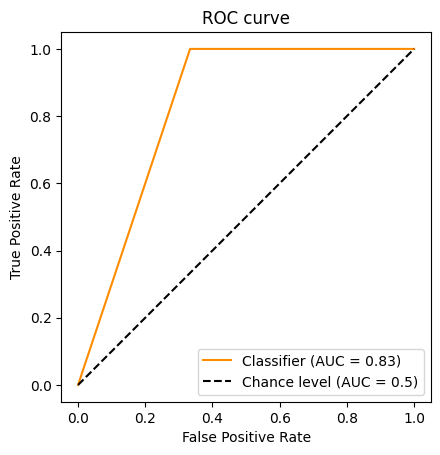

In [7]:
from sklearn.metrics import auc, RocCurveDisplay

RocCurveDisplay.from_predictions(
    classes[test],
    predictions,
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

ROC curves can seem a bit harder to interpret than accuracy values,
but we can think about them as defining our classifer's performance in a space of True Positives and False positives.

```{figure} ../images/ROC_curve.png
---
height: 400px
name: roc_curve
---
The ROC space for a "better" and "worse" classifier,
from [Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).
```

Our ROC curve also provides a useful visualization to look at the variability of our learned model across cross-validation folds !

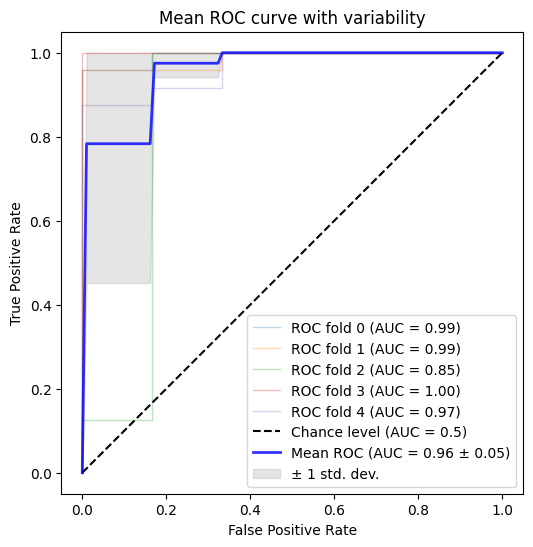

In [8]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
cv = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=30)

for fold, (train, test) in enumerate(cv.split(pooled_subjects, groups)):
    connectivity = ConnectivityMeasure(kind="correlation", vectorize=True)
    connectomes = connectivity.fit_transform(pooled_subjects[train])
    classifier = LinearSVC().fit(connectomes, classes[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        connectivity.transform(pooled_subjects[test]),
        classes[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == 4),  # n_splits - 1
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=f"Mean ROC (AUC = %0.2f ± %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"± 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

## Small sample sizes give a wide distribution of errors

Another common issue in cross-validation is when we only have access to small test set.

```{figure} ../images/varoquaux-2017-fig1.png
---
height: 400px
name: test-size
---
From {cite}`Varoquaux_2018`, this plot shows the distribution of errors between the prediction accuracy as assessed via cross-validation (average across folds) and as measured on a large independent test set for different types of neuroimaging data.
Accuracy is reported for two reasonable choices of cross-validation strategy: leave-one-out (leave-one-run-out or leave-one-subject-out in data with multiple runs or subjects), or 50-times repeated splitting of 20% of the data.
The bar and whiskers indicate the median and the 5th and 95th percentile. 
```

The results show that these confidence bounds extends at least 10% both ways;
that is, there is a 5% chance that it is 10% above the true generalization accuracy and a 5% chance this it is 10% below.
This wide confidence bound is a result of an interaction between
  1. the large sampling noise in neuroimaging data and
  2. the relatively small sample sizes that we provide to the classifier.

We can replicate this idea by systematically decreasing the size of our test set, first to 15 participants.

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
# med test set StratifiedShuffleSplit

med_strat_scores = []

cv = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=15)
for train, test in cv.split(pooled_subjects, groups):
    connectivity = ConnectivityMeasure(kind="correlation", vectorize=True)
    connectomes = connectivity.fit_transform(pooled_subjects[train])
    classifier = LinearSVC().fit(connectomes, classes[train])
    predictions = classifier.predict(
        connectivity.transform(pooled_subjects[test]))
    med_strat_scores.append(accuracy_score(classes[test], predictions))

print(f'Medium StratifiedShuffleSplit Accuracy: {np.mean(med_strat_scores):.2f} ± {np.std(med_strat_scores):.2f}')

Medium StratifiedShuffleSplit Accuracy: 0.95 ± 0.05


Then to 5.

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
# small test set StratifiedShuffleSplit

small_strat_scores = []

cv = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=5)
for train, test in cv.split(pooled_subjects, groups):
    connectivity = ConnectivityMeasure(kind="correlation", vectorize=True)
    connectomes = connectivity.fit_transform(pooled_subjects[train])
    classifier = LinearSVC().fit(connectomes, classes[train])
    predictions = classifier.predict(
        connectivity.transform(pooled_subjects[test]))
    small_strat_scores.append(accuracy_score(classes[test], predictions))

print(f'Small StratifiedShuffleSplit Accuracy: {np.mean(small_strat_scores):.2f} ± {np.std(small_strat_scores):.2f}')

Small StratifiedShuffleSplit Accuracy: 0.84 ± 0.08


Then we can compare the distributions of these accuracy scores for each cross-validation scheme:

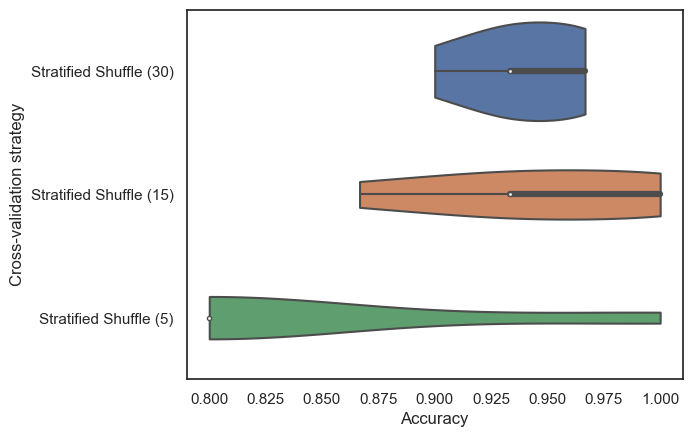

In [11]:
import seaborn as sns
sns.set_theme(style='white')

ax = sns.violinplot(
    data=[strat_scores, med_strat_scores, small_strat_scores], 
    orient='h', 
    cut=0
)
ax.set(
    yticklabels=[
        'Stratified Shuffle (30)', 
        'Stratified Shuffle (15)', 
        'Stratified Shuffle (5)'
    ],
    ylabel='Cross-validation strategy',
    xlabel='Accuracy'
);

## Avoiding data leakage between train and test

In {cite}`Varoquaux_2017`, Varoquaux and colleagues evaluated the impact of different cross-validation schemes on derived accuracy values.
We reproduce their Figure 6 below.

```{figure} ../images/varoquaux-2016-fig6.png
---
height: 400px
name: cv-strategies
---
From {cite}`Varoquaux_2017` shows the difference in accuracy measured by cross-validation and on the held-out
validation set, in intra and inter-subject settings, for different cross-validation strategies:
(1) leave one sample out, (2) leave one block of samples out (where the block is the natural unit of the experiment: subject or session), and random splits leaving out 20% of the blocks as test data, with (3) 3, (4) 10, or (5) 50 random splits. 
For inter-subject settings, leave one sample out corresponds to leaving a session out.
The box gives the quartiles, while the whiskers give the 5 and 95 percentiles.
```

We see that cross-validation schemes that "leak" information from the train to test set can give overly optimistic predictions.
For example, if we leave-one-session-out for predictions within a participant, we see that our estimated prediction accuracy from cross-validation is much higher than our prediction accuracy on a held-out validation set.
This is because different sessions from the same participant are highly-correlated;
that is, participants are likely to show similar patterns of neural responses across sessions.

In our dataset, this isn't a clear problem, since each participant was only sampled once.
It is, though, something to stay aware of !

In [12]:
# Compare with cross-validation scores for leave-one-subject-out

from sklearn.model_selection import LeaveOneOut
loo_scores = []

cv = LeaveOneOut()
for train, test in cv.split(pooled_subjects):
    connectivity = ConnectivityMeasure(kind="correlation", vectorize=True)
    connectomes = connectivity.fit_transform(pooled_subjects[train])
    classifier = LinearSVC().fit(connectomes, classes[train])
    predictions = classifier.predict(
        connectivity.transform(pooled_subjects[test]))
    loo_scores.append(accuracy_score(classes[test], predictions))

print(f'Leave-One-Out Accuracy: {np.mean(loo_scores):.2f} ± {np.std(loo_scores):.2f}')

Leave-One-Out Accuracy: 0.95 ± 0.21


```{bibliography} references.bib
:style: unsrt
:filter: docname in docnames
```